# LAMA

## 1 Установка и импорт библиотек, инициализация глобальных констант

### 1.1 Установка библиотек

In [1]:
%%capture
!pip install lightautoml
!pip install -U pandas

### 1.2 Импорт библиотек

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

pd.set_option('display.max_columns', 50)

### 1.3 Инициализация глобальных констант

In [3]:
# путь к папке с данными
path = Path('/kaggle/input/mckinsey-preprocessed')
# количество потоков
N_THREADS = 4
# количество фолдов для кросс-валидации
N_FOLDS = 5
# random state для воспроизводимости
RANDOM_STATE = 42
# размер отложенной выборки
TEST_SIZE = 0.2
# максимальное время обучения модели
TIMEOUT = 3600
# название целевой переменной
TARGET_NAME = 'Approved'

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## 2 Подготовка данных

In [5]:
train = pd.read_csv(
    path / '/kaggle/input/mckinsey-preprocessed/train_preprocessed.csv')
test = pd.read_csv(path /
                   '/kaggle/input/mckinsey-preprocessed/test_preprocessed.csv')
train

,ID,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Loan_Amount_per_Period,Credit_pct,Credit_pct_per_Period,Amount_over_pct,Amount_plus_pct,Amount_plus_pct_per_period,Amount_plus_pct_over_amount,Amount_pct_per_period,Credit_over_income,Credit_pct_over_income,Monthly_Income_in_city,Monthly_Income_at_employer,Monthly_Income_in_source_category,Monthly_Income_over_city_income,Monthly_Income_over_employeer_income,Monthly_Income_over_category_income,Age
0,APPC90493171225,Female,C10001,A,another,A,4.0,2000.0,B001,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13461.737114,2000.000000,4517.348356,0.148569,1.000000,0.442738,36
1,APPD40611263344,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0,10000.0,2650.0,1325.000,7.547170,22650.0,11325.000,1.1325,0.566250,2.857143,0.378571,4130.332287,4789.257987,4517.348356,0.847389,0.730802,0.774791,29
2,APPE70289249423,Male,another,C,another,C,4.0,2250.0,B003,G,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0,11250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,3668.495833,2250.000000,6218.750490,0.613330,1.000000,0.361809,33
3,APPF80273865537,Male,another,C,another,A,4.0,3500.0,B003,G,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0,18400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.257143,NaN,1525.000000,2700.000000,6218.750490,2.295082,1.296296,0.562814,27
4,APPG60994436641,Male,C10002,A,another,A,4.0,10000.0,B001,P,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,4465.358272,6644.750000,6218.750490,2.239462,1.504948,1.608040,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,C10006,A,COM0000010,A,1.0,4900.0,B002,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4042.877278,5781.724828,4517.348356,1.212008,0.847498,1.084707,33
69709,APPV80989824738,Female,another,C,another,A,4.0,7190.1,B002,P,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4886.480000,7190.100000,4517.348356,1.471427,1.000000,1.591664,45
69710,APPW50697209842,Female,C10022,B,another,C,4.0,1600.0,B030,P,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0,6000.0,8520.0,2130.000,2.816901,32520.0,8130.000,1.3550,0.338750,3.750000,1.331250,3472.887186,1625.000000,4517.348356,0.460712,0.984615,0.354190,24
69711,APPY50870035036,Male,C10002,A,another,C,3.0,9893.0,B002,P,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.617305,NaN,4465.358272,3265.884615,4517.348356,2.215500,3.029195,2.190002,38


In [6]:
tr_data, te_data = train_test_split(train,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=train[TARGET_NAME])

## 3 LAMA

### 3.1 Task

In [7]:
task = Task('binary', metric=roc_auc_score)

### 3.2 Roles

In [8]:
roles = {
    'target': TARGET_NAME,
    'drop': ['ID', 'DOB', 'Lead_Creation_Date'],
    'category': ['Employer_Category2', 'Var1']
}

### 3.3 Обучение модели

In [9]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    general_params={
        'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cbt', 'cbt_tuned']]
    },
    reader_params={
        'n_jobs': N_THREADS,
        'cv': N_FOLDS,
        'random_state': RANDOM_STATE
    })

In [10]:
%%time
oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)

[16:03:03] Stdout logging level is INFO.
[16:03:03] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[16:03:03] Task: binary

[16:03:03] Start automl preset with listed constraints:
[16:03:03] - time: 3600.00 seconds
[16:03:03] - CPU: 4 cores
[16:03:03] - memory: 16 GB

[16:03:03] Train data shape: (55770, 37)

[16:03:10] Layer 1 train process start. Time left 3593.38 secs
[16:03:13] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:03:26] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8210558411776837
[16:03:26] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:03:26] Time left 3577.20 secs

[16:03:30] Selector_LightGBM fitting and predicting completed
[16:03:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:04:07] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8533205267221713
[16:04:07] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:04:07] Start hyperparameters optimization for L

## 4 Результаты

In [11]:
%%time
holdout_pred = automl.predict(te_data)
print(f'Предсказания на отложенной выборке:\n{holdout_pred}')

Предсказания на отложенной выборке:
array([[0.04525771],
       [0.00226274],
       [0.00225295],
       ...,
       [0.03580574],
       [0.00187255],
       [0.01717661]], dtype=float32)
CPU times: user 2.6 s, sys: 8.01 ms, total: 2.6 s
Wall time: 1.31 s


In [12]:
print(
    f'ROC-AUC на кросс-валидации: {roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data):.5f}'
)
print(
    f'ROC-AUC на отложенной выборке: {roc_auc_score(te_data[TARGET_NAME].values, holdout_pred.data):.5f}'
)

ROC-AUC на кросс-валидации: 0.85784
ROC-AUC на отложенной выборке: 0.83926


### 4.1 Важность признаков

#### 4.1.1 Fast на основе важности признаков из LightGBM

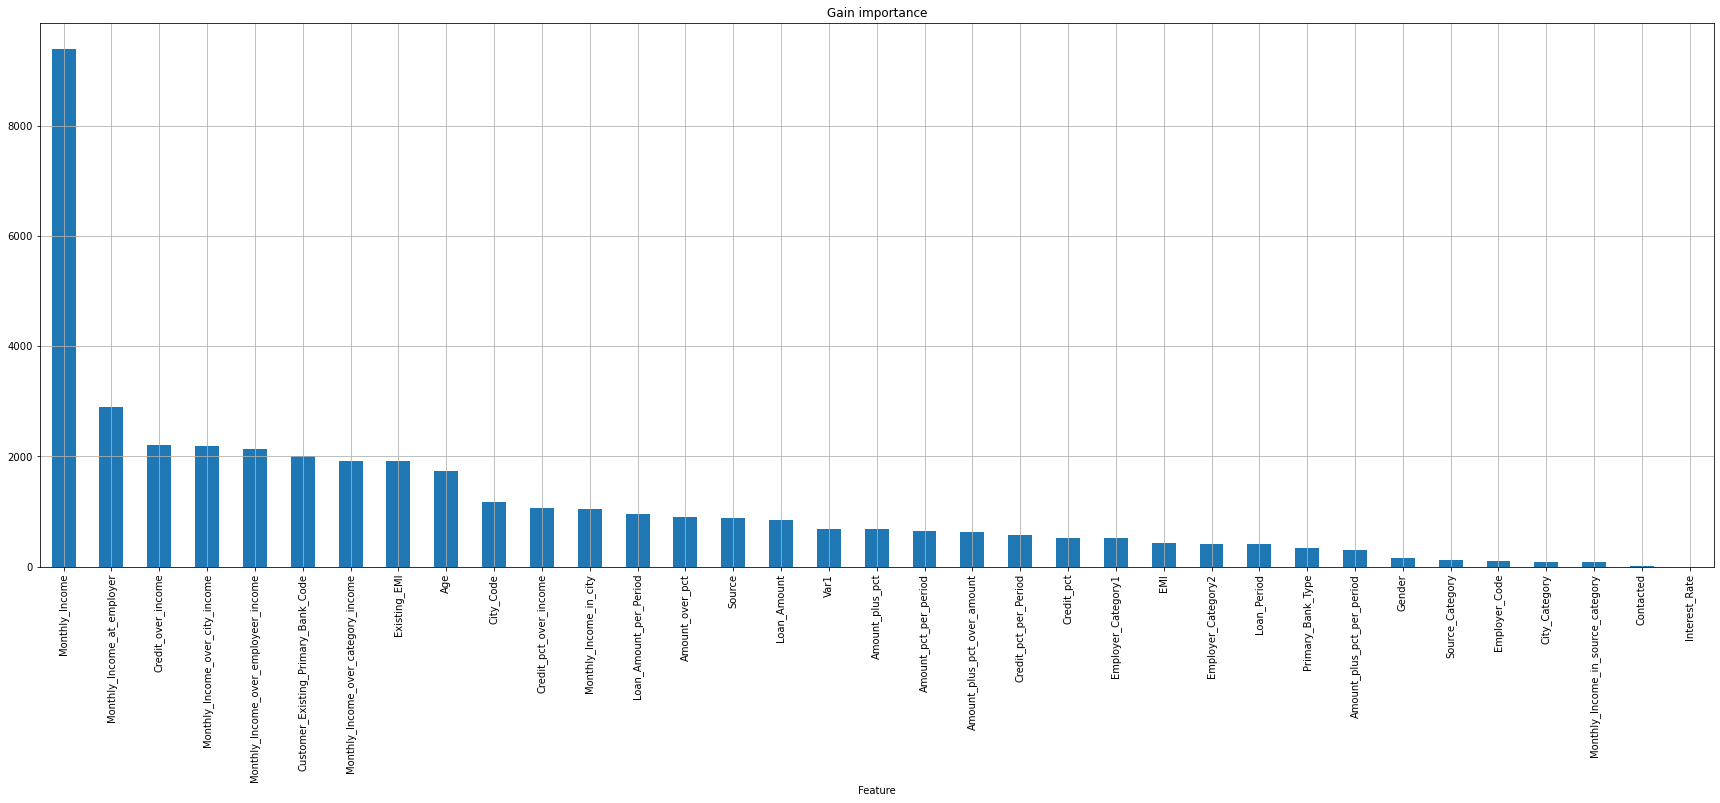

CPU times: user 842 ms, sys: 240 ms, total: 1.08 s
Wall time: 754 ms


In [13]:
%%time
fast_fi = automl.get_feature_scores('fast')
_ = fast_fi.set_index('Feature')['Importance'].plot.bar(figsize=(30, 10),
                                                        grid=True)
plt.title('Gain importance')
plt.show()

#### 4.1.2 Permutation importance

In [14]:
%%time
accurate_fi = automl.get_feature_scores('accurate', te_data, silent=False)
accurate_fi['Importance'] = accurate_fi['Importance'].round(3)

CPU times: user 1min 26s, sys: 233 ms, total: 1min 26s
Wall time: 42.7 s


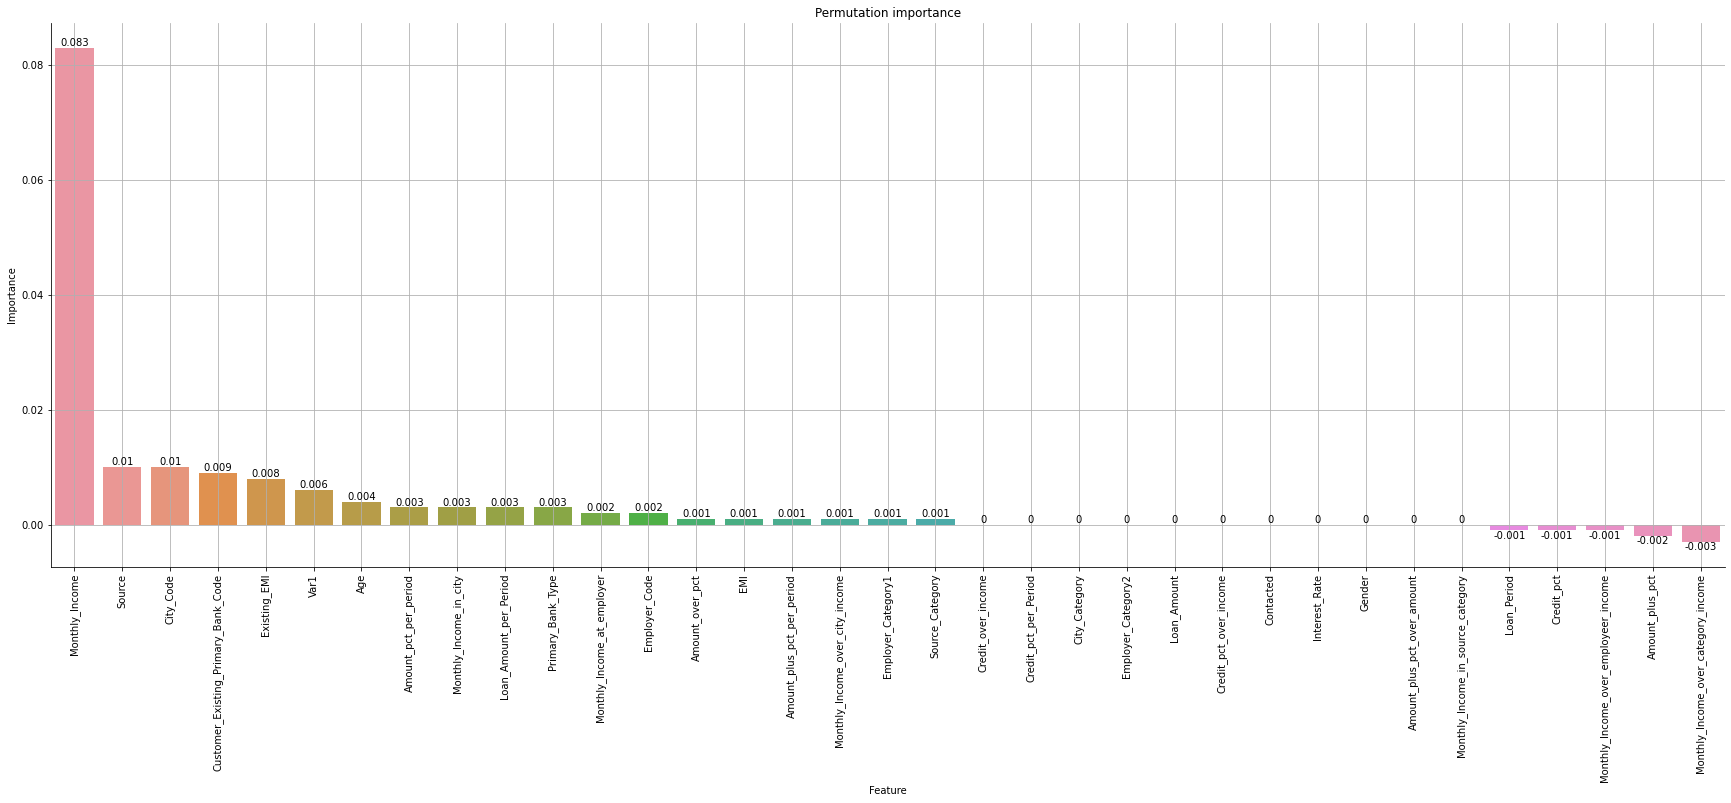

In [15]:
fig = plt.figure(figsize=(30, 10))
ax = sns.barplot(x='Feature', y='Importance', data=accurate_fi)
ax.bar_label(ax.containers[0])
for item in ax.get_xticklabels():
    item.set_rotation('vertical')
sns.despine(fig)
plt.grid()
plt.title('Permutation importance')
plt.show()

По графикам важности признаков можно сделать вывод, что основополагающим признаком при одобрении кредита является месячный доход. 

Также заметна разница между 2 методами подсчета признаков. При получении важности признаков из модели LightGBM (importance_type="gain"), самыми важными являются признаки, связанные с месячным доходом. Тогда как при подсчете важности признаков через Permutation Importance часть этих признаков (Monthly_Income_over_employeer_income, Monthly_Income_over_category_income) оказывается бесполезной.

## 5 Предсказания для тестовой выборки

In [16]:
%%time
test_pred = automl.predict(test)
print(f'Предсказания на тестовой выборке:\n{holdout_pred}')

Предсказания на тестовой выборке:
array([[0.04525771],
       [0.00226274],
       [0.00225295],
       ...,
       [0.03580574],
       [0.00187255],
       [0.01717661]], dtype=float32)
CPU times: user 4.89 s, sys: 17 ms, total: 4.91 s
Wall time: 2.37 s
